In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carotid-ultrasound-images/dataset.csv
/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202202071355560051VAS_slice_351.png
/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121847410041VAS_slice_614.png
/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202202071308300020EM VASCULAR_slice_695.png
/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202202071314560026VAS_slice_65.png
/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images/202201121823380035VAS_slice_240.png
/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultr

In [79]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [80]:
base_path = "/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/"
image_dir = base_path + "US images/"         
mask_dir = base_path + "Expert mask images/" 

In [81]:
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

In [82]:
df = pd.DataFrame({"image_path": image_files, "mask_path": mask_files})
df.shape

(1100, 2)

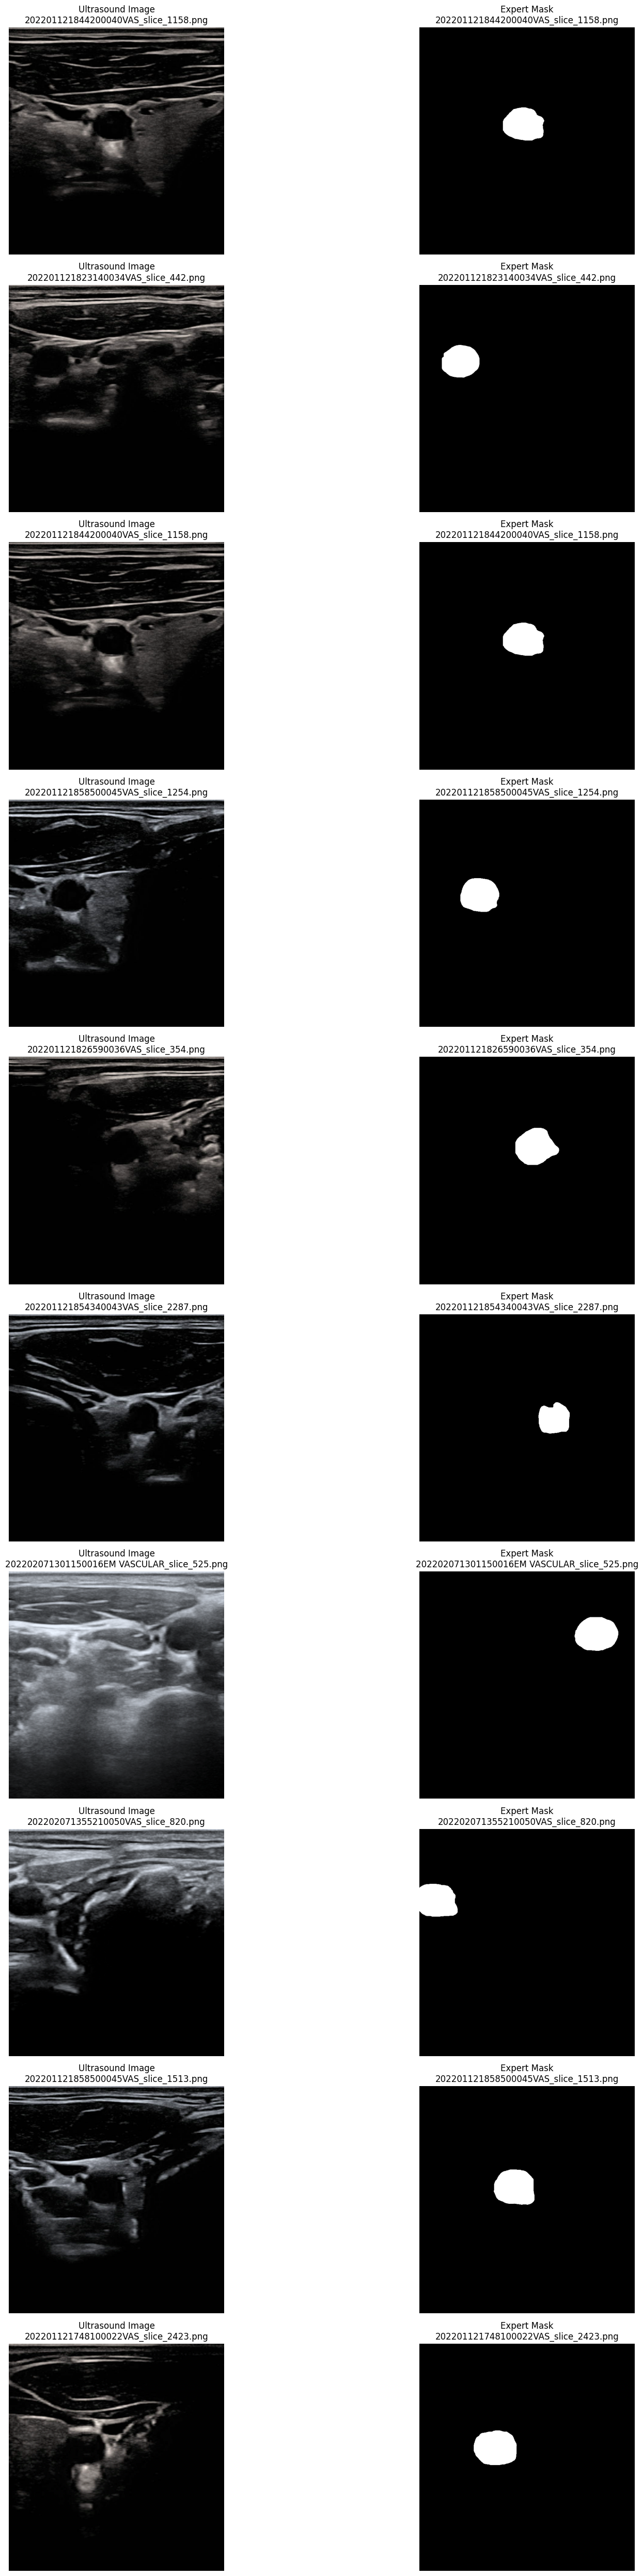

In [83]:
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))
assert all(im.split('.')[0] == mk.split('.')[0] for im, mk in zip(image_files, mask_files)), "Mismatched files!"

fig, axes = plt.subplots(10, 2, figsize=(20, 50))
for idx in range(10):
   
    random_index = random.randint(0, len(image_files)-1)
    
    img_path = os.path.join(image_dir, image_files[random_index])
    mask_path = os.path.join(mask_dir, mask_files[random_index])
    
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Ultrasound Image\n{image_files[random_index]}")
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].set_title(f"Expert Mask\n{mask_files[random_index]}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [84]:
missing_masks = [f for f in image_files if f not in mask_files]
if missing_masks:
    raise ValueError(f"Missing masks for {len(missing_masks)} images, including: {missing_masks[:3]}")

In [85]:
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

In [86]:
file_pairs = [
    (os.path.join(image_dir, f), os.path.join(mask_dir, f)) 
    for f in image_files
]
df = pd.DataFrame(file_pairs, columns=['image_path', 'mask_path'])
df

,image_path,mask_path
0,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
1,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
2,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
3,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
4,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
...,...,...
1095,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
1096,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
1097,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...
1098,/kaggle/input/carotid-ultrasound-images/Common...,/kaggle/input/carotid-ultrasound-images/Common...


In [87]:
# def extract_subject_id(filename):
#     """Extracts subject ID from filenames like:
#     - 202201121748100022VAS_slice_1069.png
#     - 202202071308300020EM VASCULAR_slice_695.png
#     """
#     parts = filename.split('_')
    
#     if len(parts) < 3:
#         raise ValueError(f"Unexpected filename format: {filename}")

#     first_part = parts[0]
    
#     timestamp_length = 18
#     if len(first_part) < timestamp_length:
#         raise ValueError(f"Unexpected first part length: {first_part}")
    
#     identifier = first_part[timestamp_length:]
    
#     subject_id = identifier.split()[0].strip() 
    
#     return subject_id

# df['subject_id'] = df['image_path'].apply(lambda x: extract_subject_id(os.path.basename(x)))

# print("Unique Subject IDs:", df['subject_id'].unique())

In [109]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
def load_data(df, image_size=(256, 256)):
    images = []
    masks = []
    for image_path, mask_path in zip(df['image_path'], df['mask_path']):
        img = load_img(image_path, target_size=image_size)
        img = img_to_array(img) / 255.0
        images.append(img)

        mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
images, masks = load_data(df)
masks = np.expand_dims(masks, axis=-1) 

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1) 

In [110]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 483ms/step - accuracy: 0.9708 - loss: 0.3663 - val_accuracy: 0.9759 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.9767 - loss: 0.0918 - val_accuracy: 0.9759 - val_loss: 0.0887 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.9769 - loss: 0.0770 - val_accuracy: 0.9759 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - accuracy: 0.9768 - loss: 0.0591 - val_accuracy: 0.9759 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.9767 - loss: 0.0523 - val_accuracy: 0.9759 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.9796 - loss: 0.0381 - val_accuracy: 0.9913 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.9944 - loss: 0.0151 - val_accura

In [90]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 256, 256, 16)   │            448 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ conv2d_152[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 128, 128, 16)   │              0 │ conv2d_153[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_154 (Conv2D)       │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_155 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_154[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 64, 64, 32)     │              0 │ conv2d_155[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_156 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_157 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_156[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 32, 32, 64)     │              0 │ conv2d_157[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_158 (Conv2D)       │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_34[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_159 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ conv2d_158[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 16, 16, 128)    │              0 │ conv2d_159[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_160 (Conv2D)       │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_35[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_161 (Conv2D)       │ (None, 16, 16, 256)    │        590,080 │ conv2d_160[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_32          │ (None, 32, 32, 256)    │              0 │ conv2d_161[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_32       

 Total params: 5,887,877 (22.46 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,925,252 (14.97 MB)

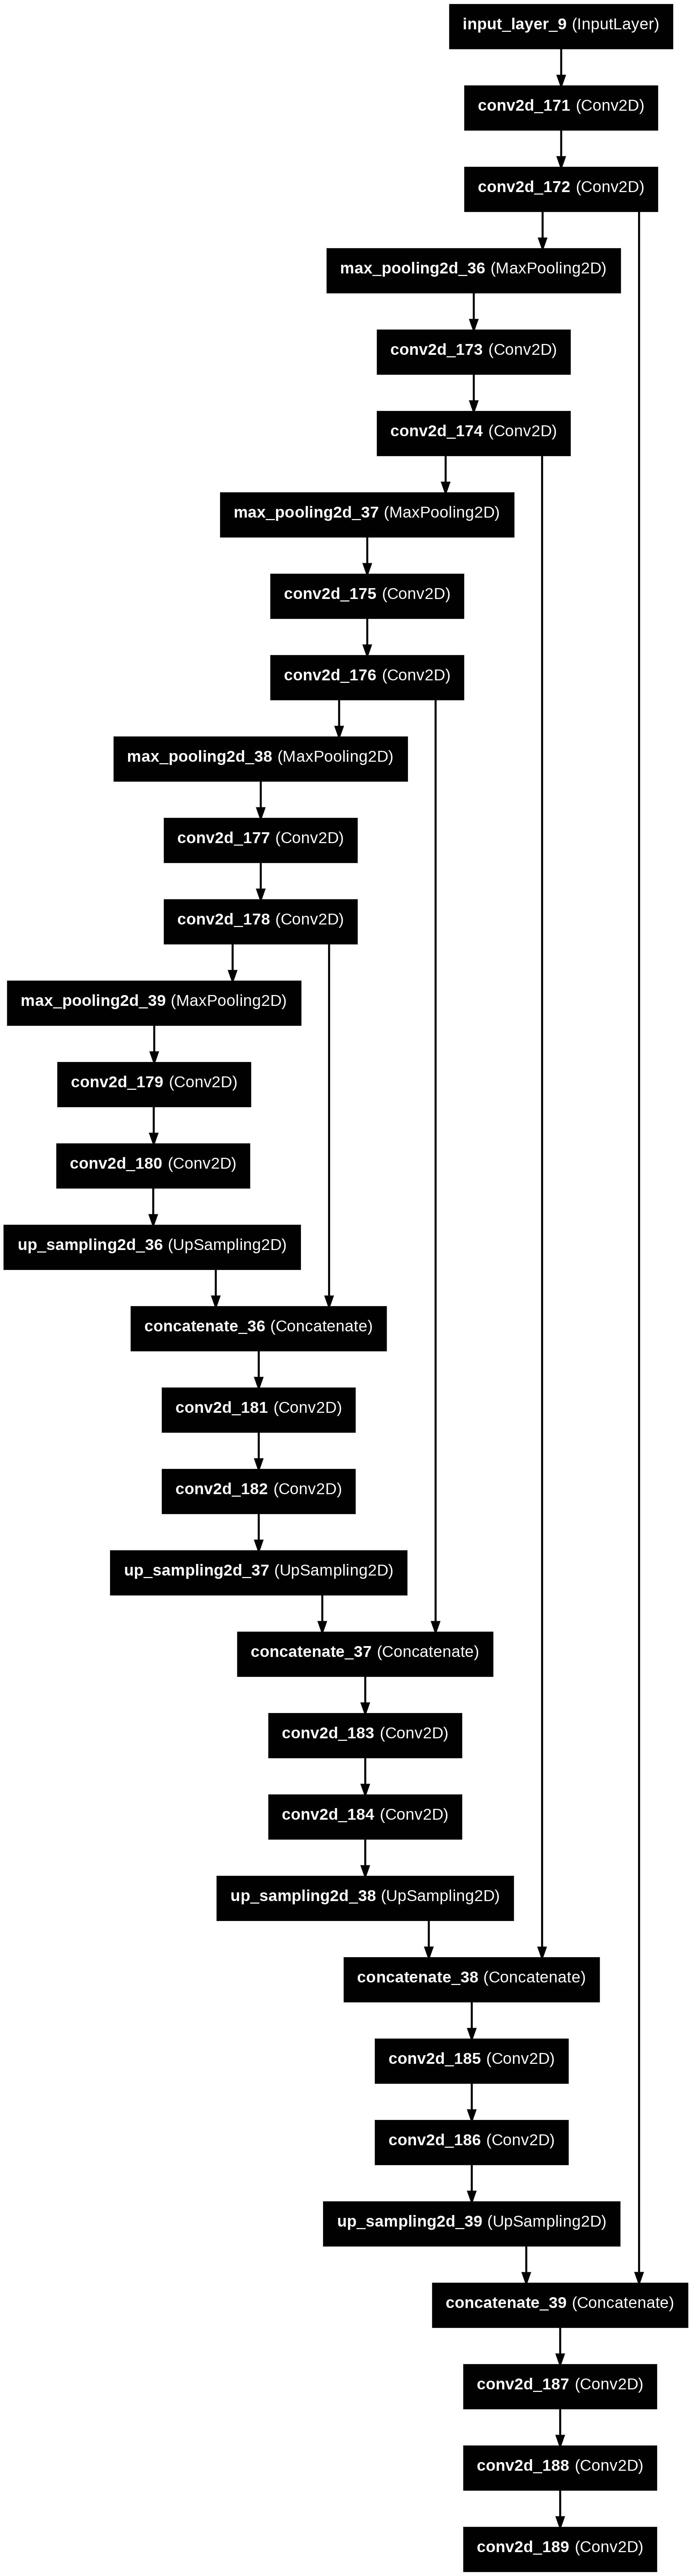

In [91]:
from tensorflow.keras.utils import plot_model
model = unet()
plot_model(model, to_file="unet_architecture.png", show_layer_names=True)
from IPython.display import Image
Image("unet_architecture.png")

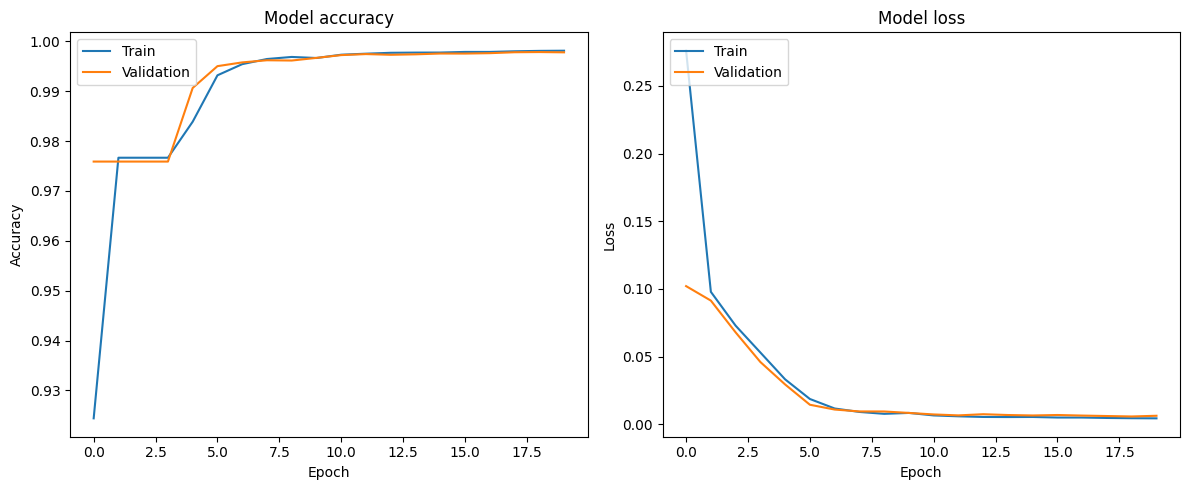

In [92]:
def plot_history(history):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    else:
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper left')

    plt.tight_layout() 
    plt.show()

plot_history(history)

In [111]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 0.0
    return intersection / union

def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    if total == 0:
        return 0.0
    return 2 * intersection / total

In [112]:
y_pred_binary = (model.predict(X_test) > 0.5).astype(bool)
y_test_binary = y_test.astype(bool)

iou = calculate_iou(y_test_binary.squeeze(), y_pred_binary.squeeze())
dice = calculate_dice(y_test_binary.squeeze(), y_pred_binary.squeeze())

print(f"IoU: {iou}")
print(f"Dice: {dice}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step
IoU: 0.9146022033170818
Dice: 0.9553965849746934


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


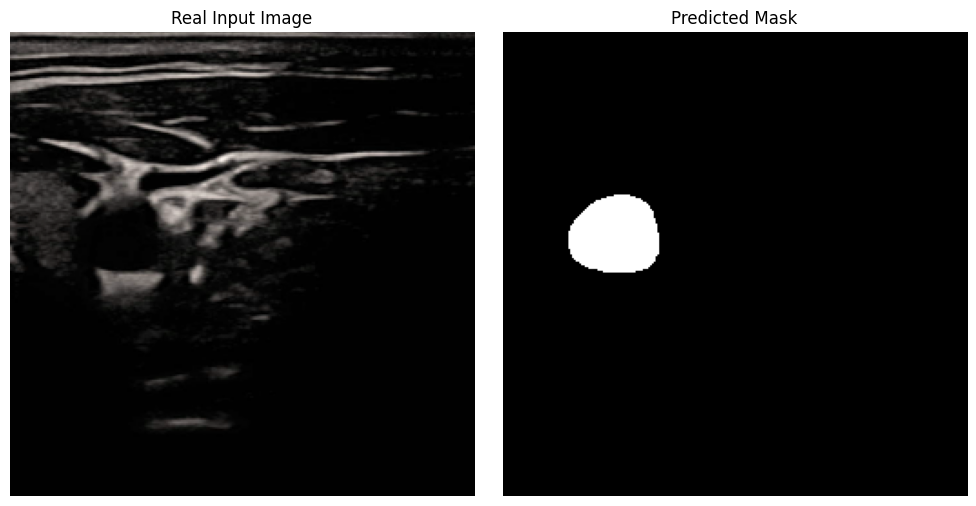

In [113]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your real test image (change this to your image path)
real_image_path = "/kaggle/input/carotid-ultrasound-images/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/US images/202201121748100022VAS_slice_1080.png"  # ← Update as needed

# Preprocess real input image
def preprocess_single_image(img_path, target_size=(256, 256)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Test function for real image
def test_real_image(image_path):
    # Preprocess input image
    input_image = preprocess_single_image(image_path)

    # Predict using trained model
    prediction = model.predict(input_image)[0, :, :, 0]  # Get 2D prediction

    # Load original image for display
    img_show = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img_show = cv2.resize(img_show, (256, 256))

    # Plot original image and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_show)
    plt.title("Real Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction > 0.5, cmap='gray')  # Show binary mask
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔁 Run test
test_real_image(real_image_path)